In [1]:
!pip install mindspore==2.6.0
!pip install mindnlp==0.4.1
!pip install soundfile

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [2]:
import mindspore
from mindnlp.transformers import AutoProcessor, AutoModel
import soundfile as sf
import mindspore._c_expression as _c_expression
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
from mindspore import ops
# 底层算子修复兼容
if not hasattr(_c_expression, 'Tensor'):
    _c_expression.Tensor = mindspore.Tensor

def tensor_log_softmax(self, dim=-1):
    log_softmax_op = ops.LogSoftmax(axis=dim)
    return log_softmax_op(self)

if not hasattr(mindspore.Tensor, 'log_softmax'):
    mindspore.Tensor.log_softmax = tensor_log_softmax

/usr/local/lib64/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib64/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib64/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib64/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.632 seconds.
Prefix dict h

In [3]:
def generate_bark_speech(texts, voice_preset=None, model_name="suno/bark-small"):
    try:
        # 加载处理器和模型
        processor = AutoProcessor.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        # 推理模式
        model.set_train(False)
        # 打印一下模型结构
        print(model)
        # 处理输入文本
        inputs = processor(
            text=texts,
            return_tensors="ms",
            voice_preset=voice_preset
        )
        
        # 生成语音
        speech_values = model.generate(**inputs, do_sample=True)
        
        return speech_values
    
    except Exception as e:
        print(f"生成语音时出错: {e}")
        return None

In [4]:
samplerate = 24000
text = ["欢快地奔跑的小溪，像清澈的画卷"]
voice_preset = None

In [5]:
speech = generate_bark_speech(text, voice_preset=voice_preset)
if speech is not None:
    sf.write("output.wav", speech.numpy().squeeze(), samplerate=samplerate)

[WARNING] DEVICE(22485,fffdea0fe1a0,python3):2025-12-01-01:00:54.711.214 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_vmm_adapter.h:152] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(22485,fffdea0fe1a0,python3):2025-12-01-01:00:54.711.263 [mindspore/ccsrc/plugin/res_manager/ascend/mem_manager/ascend_vmm_adapter.h:180] CheckVmmDriverVersion] Open file /usr/local/Ascend/driver/version.info failed.


BarkModel(
  (semantic): BarkSemanticModel(
    (input_embeds_layer): Embedding(129600, 768)
    (position_embeds_layer): Embedding(1024, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x BarkBlock(
        (layernorm_1): BarkLayerNorm()
        (layernorm_2): BarkLayerNorm()
        (attn): BarkSelfAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (att_proj): Linear (768 -> 2304)
          (out_proj): Linear (768 -> 768)
        )
        (mlp): BarkMLP(
          (in_proj): Linear (768 -> 3072)
          (out_proj): Linear (3072 -> 768)
          (dropout): Dropout(p=0.0, inplace=False)
          (gelu): GELU(approximate='none')
        )
      )
    )
    (layernorm_final): BarkLayerNorm()
    (lm_head): Linear (768 -> 10048)
  )
  (coarse_acoustics): BarkCoarseModel(
    (input_embeds_layer): Embedding(12096, 768)
    (position_embeds_layer): Embedding(1024,

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [6]:
# 播放一下
if speech is not None:
    print("播放音频")
    display(Audio(speech.numpy().squeeze(), rate=24000))

播放音频


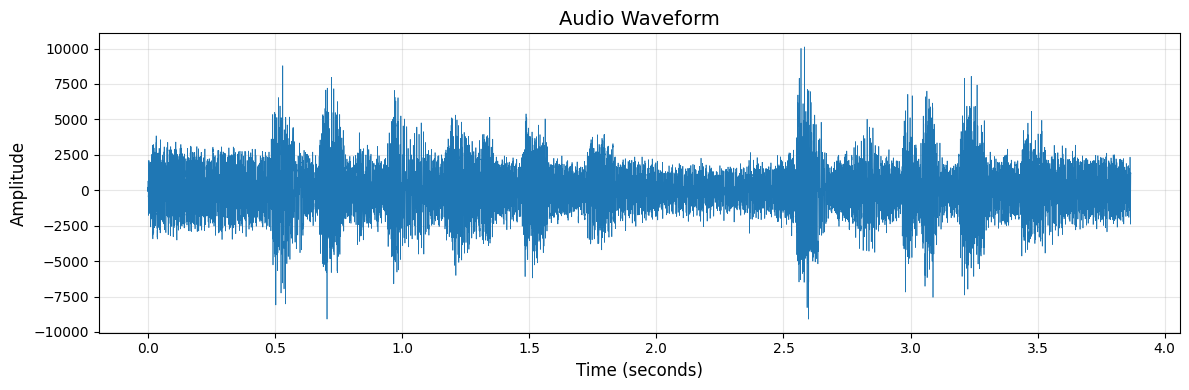

In [7]:
import wave
audio_path = "output.wav"  
wf = wave.open(audio_path, 'rb')

n_channels = wf.getnchannels()    
samp_width = wf.getsampwidth()    
framerate = wf.getframerate()     
n_frames = wf.getnframes()        

frames = wf.readframes(n_frames)
wf.close()  

if samp_width == 1:
    dtype = np.uint8
elif samp_width == 2:
    dtype = np.int16
elif samp_width == 4:
    dtype = np.int32
else:
    raise ValueError("不支持的采样宽度")

audio_data = np.frombuffer(frames, dtype=dtype)

if n_channels > 1:
    audio_data = audio_data.reshape(-1, n_channels).mean(axis=1)

time_axis = np.linspace(0, n_frames / framerate, num=len(audio_data))

plt.figure(figsize=(12, 4))  
plt.plot(time_axis, audio_data, color='#1f77b4', linewidth=0.5)
plt.title('Audio Waveform', fontsize=14)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(alpha=0.3)  
plt.tight_layout()   
plt.show()